In [69]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from skimage import io

from scipy.special import logsumexp
from sklearn.cluster import KMeans

import PIL.Image
import IPython.display

perform_computation = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def find_H(X, mu):
    """
    Calculate the matrix H_ij for the E-step.

    Parameters:
            X (np.array):  A numpy array of the shape (N,d) where N is the number of pixels in the image
            (i.e., number of data points in this problem)
            and d is the number of fundamental pixel colors (i.e., dimension of the data space in this problem).

            mu (np.array): A numpy array of the shape (K,d) where K is the target number of clusters for clustering
            and d is the number of colors (i.e., dimension of the data space in this problem).

    Returns:
            H (np.array): H_ij matrix for E-step with shape of (N, K) and np.float64 data type.
    """
    N = X.shape[0]
    K = mu.shape[0]
    assert X.shape[1] == mu.shape[1]

    # your code here
    #d_by_K_ones = np.ones((d, K))
    #N_by_d_ones = np.ones((N, d))
    # NOTE: multiplying by matrices of 1s is useful to keep shapes as defined in the math
    # solution, but really broadcasting is a better way to solve the problem.
    #H1_ = (X**2) @ d_by_K_ones
    H1 = (X**2).sum(axis=1, keepdims=True, dtype=np.float64)
    # Tile can also be used to keep shapes of the matrices by repeating colums/rows, but
    # still broadcasting is better
    #H1 = np.tile(H1, (1, K))
    #H2_ = N_by_d_ones @ (mu**2).T
    H2 = (mu**2).sum(axis=1, dtype=np.float64)
    #H2 = np.tile(H2, (1, N)).T
    H3 = X @ mu.T
    H = ((-2*H3) + H2 + H1)*(-1/2)
    #H__ = (H1 + H2 - (2*H3))*(-1/2)

    assert H.shape == (N,K)
    assert H.dtype == np.float64
    return H

some_X = np.array([[ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8,  9],
                   [ 0, 11, 12, 13,  4],
                   [15, 16, 17,  8, 19],
                   [ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8, 13],
                   [ 4, 15,  0,  5,  0]])

some_mu = np.array([[ 0,  1, 18, 15,  5],
                    [13,  9, 23,  3, 22],
                    [ 2, 10, 17,  4,  8]])

assert np.array_equal(find_H(some_X, some_mu), np.array([[ -90.5, -339. ,  -63.5],
                                                         [-218. , -281.5,  -81. ],
                                                         [ -70.5, -359. ,  -63.5],
                                                         [-348. ,  -61.5, -171. ],
                                                         [ -90.5, -339. ,  -63.5],
                                                         [-242. , -237.5,  -93. ],
                                                         [-330.5, -567. , -191.5]]))

In [36]:
def find_logW(H, log_pi):
    """
    Calculate the logW_ij matrix for the E-step.

    Parameters:
            H (np.array):  A numpy array of the shape (N,K)
            where N is the number of pixels in the image and K is the number of clusters.

            log_pi (np.array): A numpy array of the shape (K,1) where K is the number of clusters.

    Returns:
            logW (np.array): lowW_ij matrix for the E-step with shape of (N, K).
    """

    N, K = H.shape

    # your code here
    E = H + log_pi.T
    F = logsumexp(E, axis=1, keepdims=True)
    logW = E - F

    assert logW.shape == (N,K)
    assert not np.isnan(logW).any()
    assert not np.isinf(logW).any()
    return logW

some_X = np.array([[ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8,  9],
                   [ 0, 11, 12, 13,  4],
                   [15, 16, 17,  8, 19],
                   [ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8, 13],
                   [ 4, 15,  0,  5,  0]])

some_mu = np.array([[ 0,  1, 18, 15,  5],
                    [13,  9, 23,  3, 22],
                    [ 2, 10, 17,  4,  8]])

some_H = np.array([[ -90.5, -339. ,  -63.5],
                   [-218. , -281.5,  -81. ],
                   [ -70.5, -359. ,  -63.5],
                   [-348. ,  -61.5, -171. ],
                   [ -90.5, -339. ,  -63.5],
                   [-242. , -237.5,  -93. ],
                   [-330.5, -567. , -191.5]])

some_log_pi = np.log(some_mu.sum(axis=1)/some_mu.sum()).reshape(-1,1)

some_logW = find_logW(some_H, some_log_pi)

assert np.allclose(some_logW.round(2), np.array([[ -27.05, -274.97,   -0.  ],
                                                 [-137.05, -199.97,    0.  ],
                                                 [  -7.05, -294.97,   -0.  ],
                                                 [-287.08,    0.  , -110.03],
                                                 [ -27.05, -274.97,   -0.  ],
                                                 [-149.05, -143.97,    0.  ],
                                                 [-139.05, -374.97,    0.  ]]))

In [37]:
def update_logpi(logW):
    """
    Compute the log pi vector.

    Parameters:
            logW (np.array): A numpy array of the shape (N,K)
            where N is the number of pixels in the image and K is the number of clusters.

    Returns:
            log_pi (np.array):  log pi vector with shape of (K, 1).
    """

    N,K = logW.shape

    # your code here
    log_pi = logsumexp(logW.T, axis=1, keepdims=True) - np.log(N)

    assert log_pi.shape == (K,1)
    assert not np.isnan(log_pi).any()
    assert not np.isinf(log_pi).any()

    return log_pi

some_logW = np.array([[ -27.05, -274.97,   -0.  ],
                      [-137.05, -199.97,    0.  ],
                      [  -7.05, -294.97,   -0.  ],
                      [-287.08,    0.  , -110.03],
                      [ -27.05, -274.97,   -0.  ],
                      [-149.05, -143.97,    0.  ],
                      [-139.05, -374.97,    0.  ]])

some_logpi_new = update_logpi(some_logW)

assert np.array_equal(some_logpi_new.round(2), np.array([[-9.  ],
                                                         [-1.95],
                                                         [-0.15]]))

In [66]:
def update_mu(X, logW):
    """
    Compute the updated mu matrix.

    Parameters:
            X (np.array): A numpy array of the shape (N,d)
            where N is the number of pixels in the image (i.e., number of data points in this problem)
            and d is the number of fundamental pixel colors (i.e., dimension of the data space in this problem).

            logW (np.array): A numpy array of the shape (N,K)
            where N is the number of documents and K is the number of clusters.

    Returns:
            mu (np.array):  mu matrix with shape of (K, d).
    """

    N,K = logW.shape
    d = X.shape[1]
    assert X.shape[0] == N

    # your code here
    R = np.exp(logW.T)
    Num = np.log(R @ X)
    Den = logsumexp(logW, axis=0, keepdims=True).reshape(-1, 1)
    mu = np.exp(Num - Den)

    # Why is this  solution no numerically stable?
    #mu_ = (R @ X) / np.sum(R, axis=1, keepdims=True)

    assert mu.shape == (K,d)
    assert not np.isnan(mu).any()
    assert not np.isinf(mu).any()
    return mu


some_X = np.array([[ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8,  9],
                   [ 0, 11, 12, 13,  4],
                   [15, 16, 17,  8, 19],
                   [ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8, 13],
                   [ 4, 15,  0,  5,  0]])

some_logW = np.array([[ -27.05, -274.97,   -0.  ],
                      [-137.05, -199.97,    0.  ],
                      [  -7.05, -294.97,   -0.  ],
                      [-287.08,    0.  , -110.03],
                      [ -27.05, -274.97,   -0.  ],
                      [-149.05, -143.97,    0.  ],
                      [-139.05, -374.97,    0.  ]])

some_mu_new = update_mu(some_X, some_logW)

assert np.array_equal(some_mu_new.round(3), np.array([[ 0.   , 11.   , 12.   , 13.   ,  4.   ],
                                                      [15.   , 16.   , 17.   ,  8.   , 19.   ],
                                                      [ 2.333, 10.   ,  8.333,  6.667,  5.667]]))

In [67]:
def GMM(X, K, initialization_method='kmeans', iterations=100, seed=12345):
    N, d = X.shape
    pi_init = np.ones((K,1))/float(K)

    np_random = np.random.RandomState(seed=seed)
    if initialization_method == 'random_pixels':
        mu_init = X[np_random.choice(N, K), :] # mu.shape = (K, d)
    elif initialization_method == 'kmeans':
        kmeans = KMeans(n_clusters=K, random_state=np_random).fit(X)
        mu_init = kmeans.cluster_centers_  # mu.shape = (K, d)

    log_pi = np.log(pi_init) #log_pi.shape = (K,1)
    mu = mu_init

    for iteration in range(iterations):
        print('.', end='')
        #The E-Step
        H = find_H(X, mu)
        logW = find_logW(H, log_pi)

        #The M-Step
        log_pi = update_logpi(logW)
        mu = update_mu(X, logW)
    print('', end=' ')

    return mu, H, log_pi

In [68]:
def segment(raw_image, K, initialization_method ='random_pixels', seed=12345):
    mu, H, log_pi = GMM(X=raw_image.reshape(-1, 3), K=K,
                        initialization_method=initialization_method,
                        iterations=10, seed=seed)
    reconst_image = mu[H.argmax(axis=1), :].reshape(*raw_image.shape)

    fig, axes = plt.subplots(1,2, figsize=(8,4), dpi=144)

    ax = axes[0]
    ax.imshow(raw_image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Original Image')

    ax = axes[1]
    ax.imshow(reconst_image.astype(np.uint8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Segmented Image (K={K})')

    fig.tight_layout()

.......... .......... .......... 

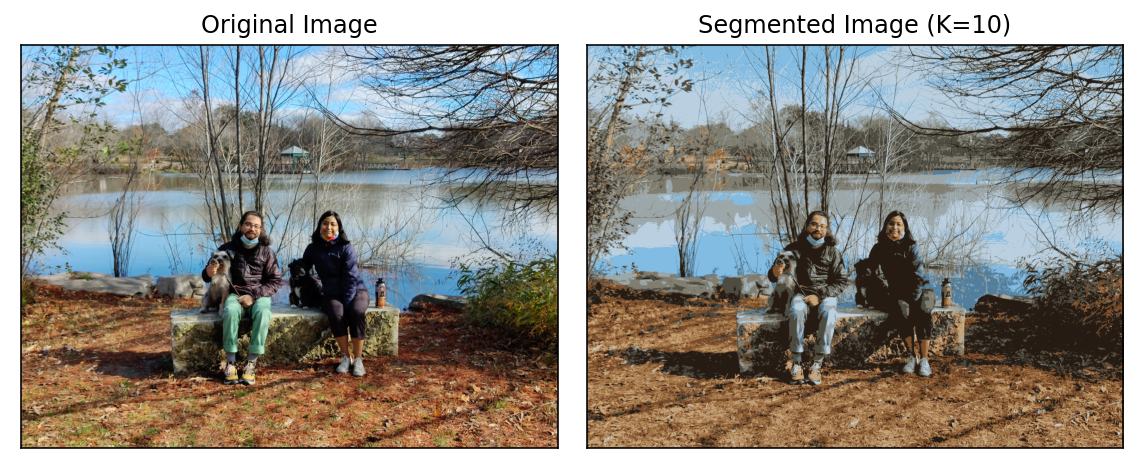

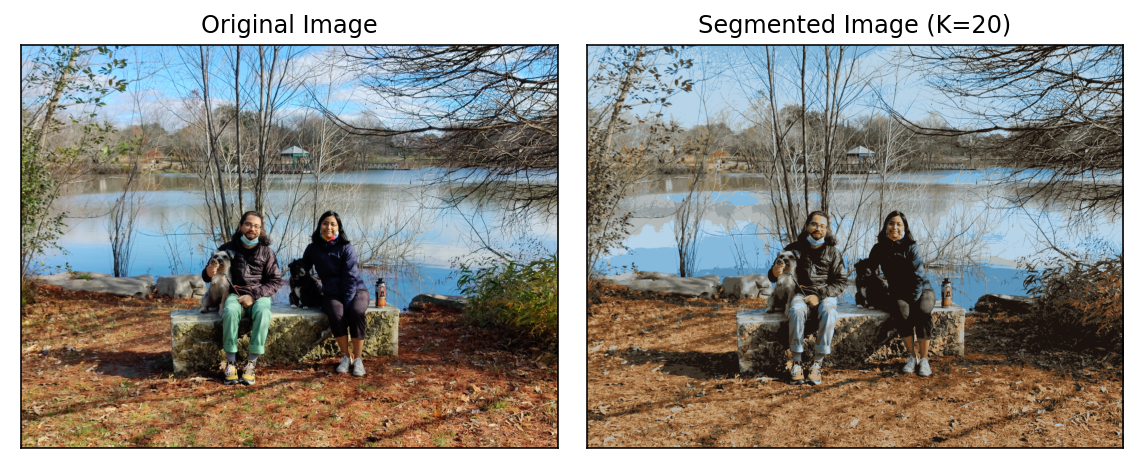

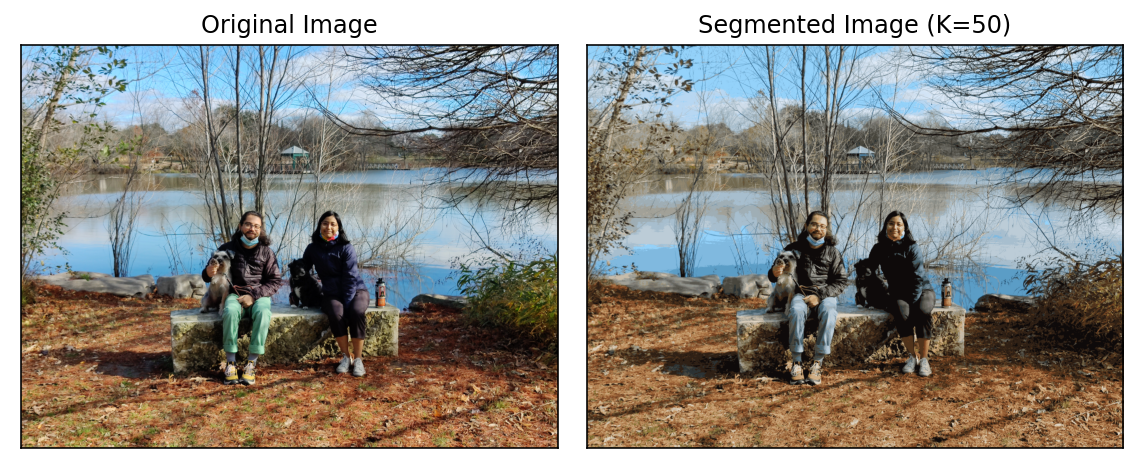

In [70]:
if perform_computation:
    raw_image = io.imread('./IMG_20210101_135253.jpg')
    segment(raw_image, 10)
    segment(raw_image, 20)
    segment(raw_image, 50)